**Key Ideas**

- Explore how changes in beta influence changes in S, I and R in the SIRS model
- Explore different timings and initiations of lockdowns
- Maybe have a look at the facemask study
- See if I can implement R0 into this

## Basic SIR Model

This is a basic SIR model which assumes that when someone recovers. they gain immunity forever.

By changing the beta values, this could represent lockdowns / face masks.

A reduction in beta reduces transmission. Beta is a value that represents a (contact rate) and p (probability of transmission) and therefore reducing beta would reduce the amount of people getting infected

R0 is commonly referred to in the literature. This is basically the beta / gamma and refers to the amount of people one person would infect. So as beta decreases, the R0 would decrease. 

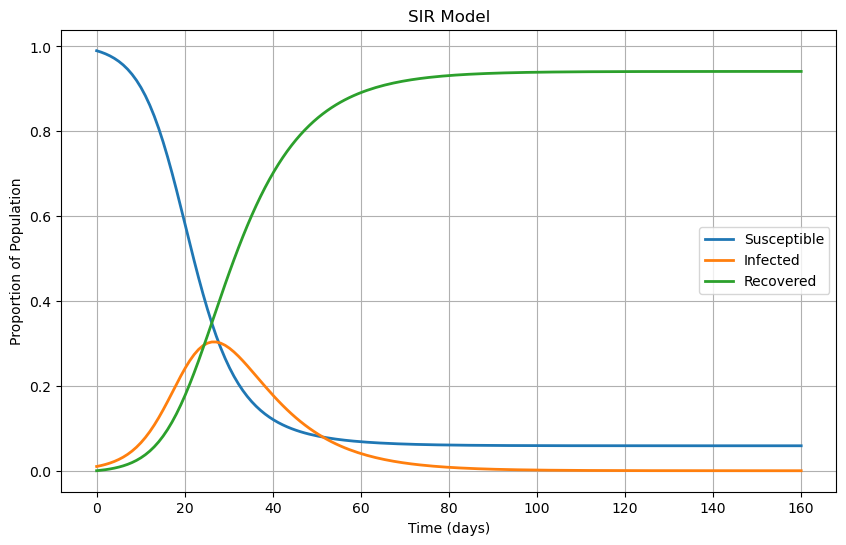

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.3  # Infection rate
gamma = 0.1  # Recovery rate

# Initial conditions
S0 = 0.99  # Initial fraction of the population that is susceptible
I0 = 0.01  # Initial fraction of the population that is infected
R0 = 0.0   # Initial fraction of the population that is recovered
initial_conditions = [S0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# SIR model differential equations
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

# Solve the differential equations
solution = odeint(sir_model, initial_conditions, t, args=(beta, gamma))
S, I, R = solution.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', linewidth=2)
plt.plot(t, I, label='Infected', linewidth=2)
plt.plot(t, R, label='Recovered', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIR Model')
plt.legend()
plt.grid(True)
plt.show()


## SIRS Model

In this model, some of the recovered population do not gain immunity. 

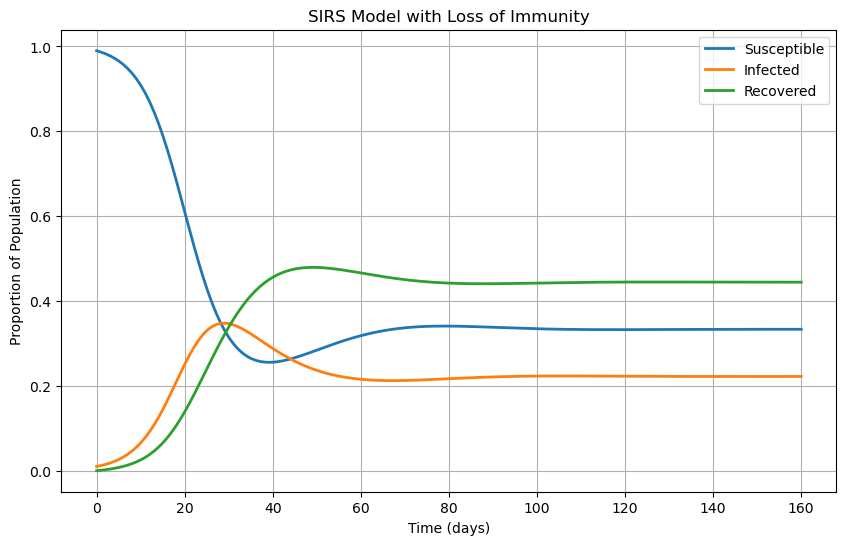

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.3    # Infection rate
gamma = 0.1   # Recovery rate
delta = 0.05  # Rate of loss of immunity

# Initial conditions
S0 = 0.99     # Initial fraction of susceptible population
I0 = 0.01     # Initial fraction of infected population
R0 = 0.0      # Initial fraction of recovered population
initial_conditions = [S0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# SIRS model differential equations
def sirs_model(y, t, beta, gamma, delta):
    S, I, R = y
    dS_dt = -beta * S * I + delta * R  # Susceptibles increase as immunity wanes
    dI_dt = beta * S * I - gamma * I   # Infected individuals
    dR_dt = gamma * I - delta * R      # Recovered individuals lose immunity over time
    return [dS_dt, dI_dt, dR_dt]

# Solve the differential equations
solution = odeint(sirs_model, initial_conditions, t, args=(beta, gamma, delta))
S, I, R = solution.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', linewidth=2)
plt.plot(t, I, label='Infected', linewidth=2)
plt.plot(t, R, label='Recovered', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIRS Model with Loss of Immunity')
plt.legend()
plt.grid(True)
plt.show()


**Testing different beta values in for SIRS model**

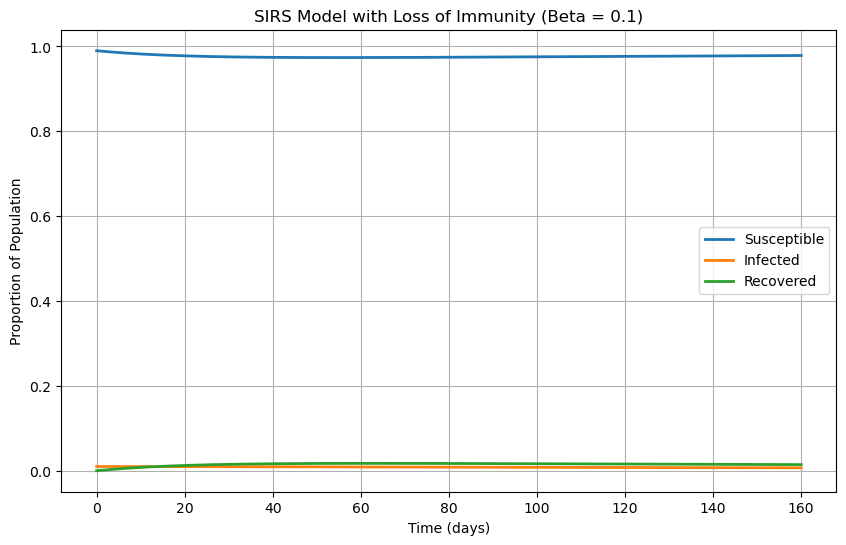

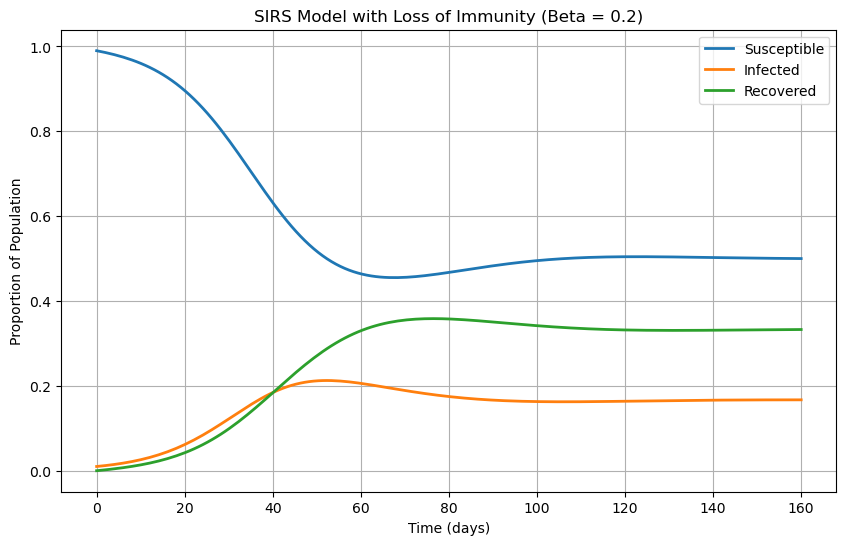

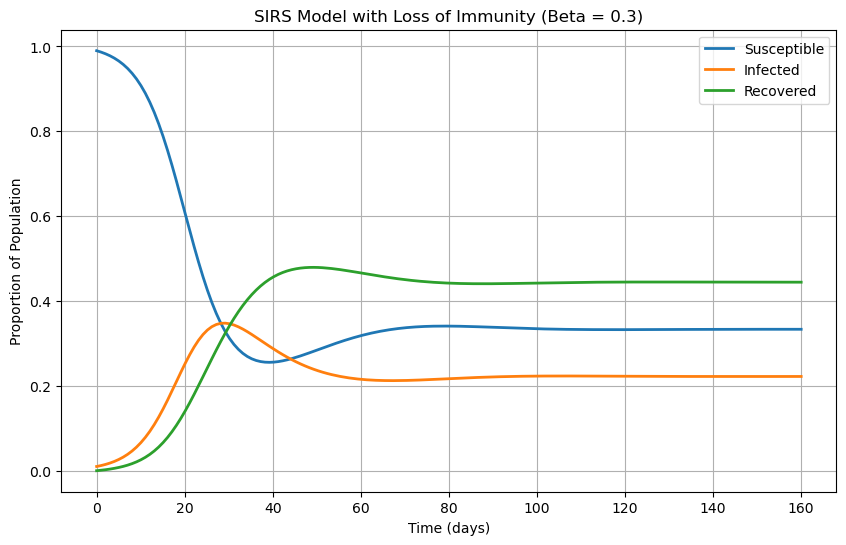

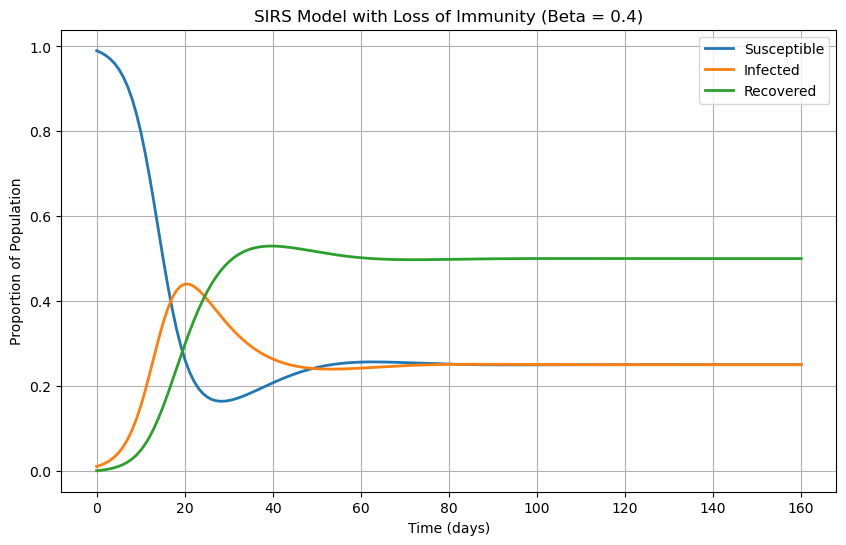

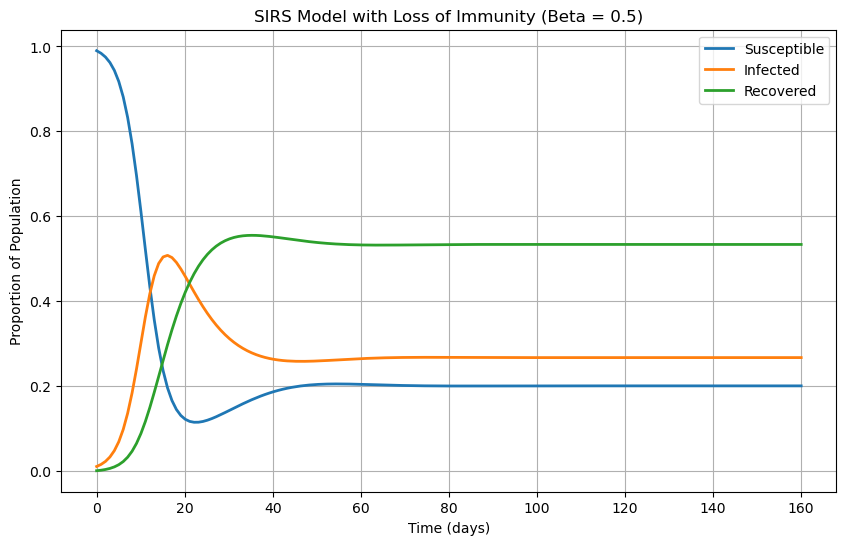

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
gamma = 0.1   # Recovery rate
delta = 0.05  # Rate of loss of immunity
beta_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Different infection rates to test

# Initial conditions
S0 = 0.99     # Initial fraction of susceptible population
I0 = 0.01     # Initial fraction of infected population
R0 = 0.0      # Initial fraction of recovered population
initial_conditions = [S0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# SIRS model differential equations
def sirs_model(y, t, beta, gamma, delta):
    S, I, R = y
    dS_dt = -beta * S * I + delta * R  # Susceptibles increase as immunity wanes
    dI_dt = beta * S * I - gamma * I   # Infected individuals
    dR_dt = gamma * I - delta * R      # Recovered individuals lose immunity over time
    return [dS_dt, dI_dt, dR_dt]

# Loop through each beta value and plot the results
for beta in beta_values:
    # Solve the differential equations for the current beta value
    solution = odeint(sirs_model, initial_conditions, t, args=(beta, gamma, delta))
    S, I, R = solution.T

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, S, label='Susceptible', linewidth=2)
    plt.plot(t, I, label='Infected', linewidth=2)
    plt.plot(t, R, label='Recovered', linewidth=2)
    plt.xlabel('Time (days)')
    plt.ylabel('Proportion of Population')
    plt.title(f'SIRS Model with Loss of Immunity (Beta = {beta})')
    plt.legend()
    plt.grid(True)
    plt.show()


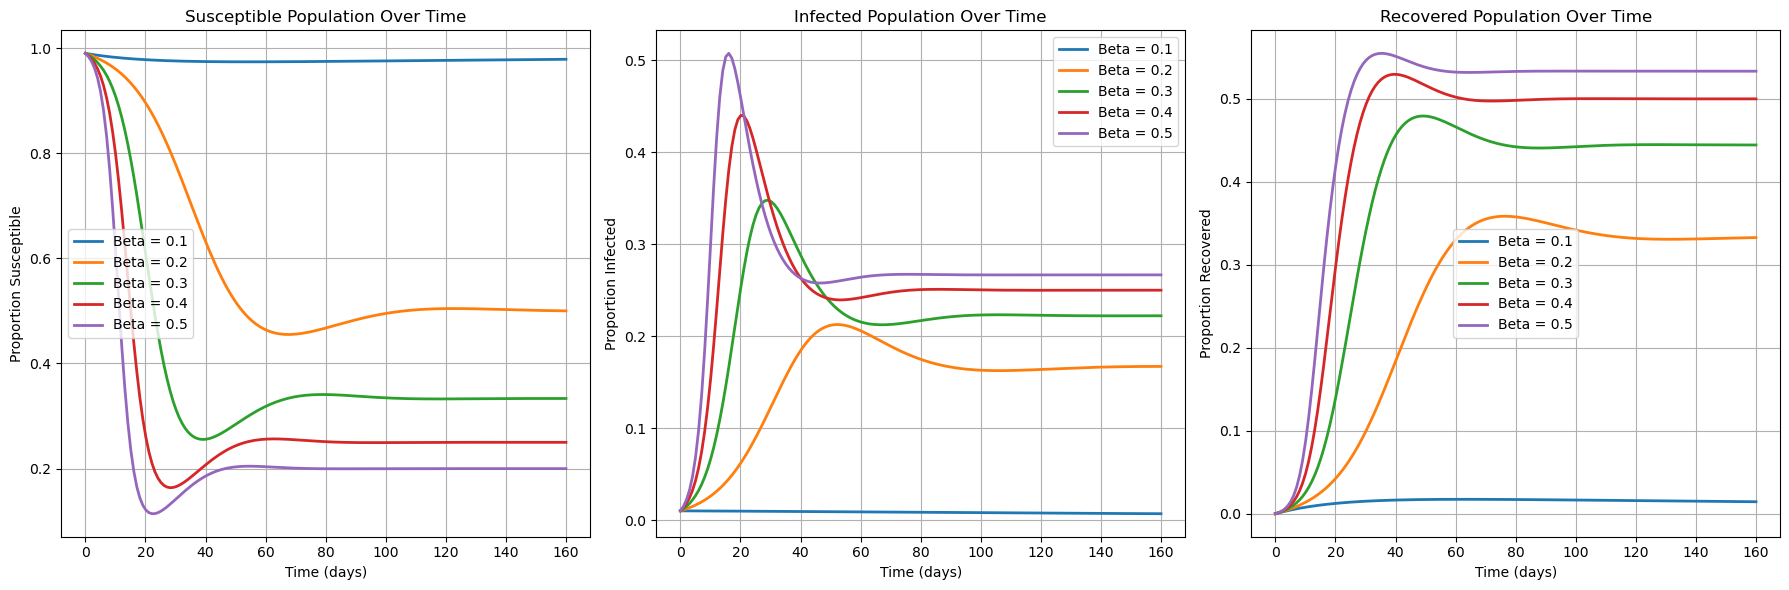

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
gamma = 0.1   # Recovery rate
delta = 0.05  # Rate of loss of immunity
beta_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Different infection rates to test

# Initial conditions
S0 = 0.99     # Initial fraction of susceptible population
I0 = 0.01     # Initial fraction of infected population
R0 = 0.0      # Initial fraction of recovered population
initial_conditions = [S0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# Store results for each beta value
S_results = []
I_results = []
R_results = []

# SIRS model differential equations
def sirs_model(y, t, beta, gamma, delta):
    S, I, R = y
    dS_dt = -beta * S * I + delta * R  # Susceptibles increase as immunity wanes
    dI_dt = beta * S * I - gamma * I   # Infected individuals
    dR_dt = gamma * I - delta * R      # Recovered individuals lose immunity over time
    return [dS_dt, dI_dt, dR_dt]

# Solve the model for each beta and store results
for beta in beta_values:
    solution = odeint(sirs_model, initial_conditions, t, args=(beta, gamma, delta))
    S, I, R = solution.T
    S_results.append(S)
    I_results.append(I)
    R_results.append(R)

# Plotting all susceptibles, infecteds, and recovereds on separate graphs
plt.figure(figsize=(18, 6))

# Susceptible plot
plt.subplot(1, 3, 1)
for i, beta in enumerate(beta_values):
    plt.plot(t, S_results[i], label=f'Beta = {beta}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Susceptible')
plt.title('Susceptible Population Over Time')
plt.legend()
plt.grid(True)

# Infected plot
plt.subplot(1, 3, 2)
for i, beta in enumerate(beta_values):
    plt.plot(t, I_results[i], label=f'Beta = {beta}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Infected')
plt.title('Infected Population Over Time')
plt.legend()
plt.grid(True)

# Recovered plot
plt.subplot(1, 3, 3)
for i, beta in enumerate(beta_values):
    plt.plot(t, R_results[i], label=f'Beta = {beta}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Recovered')
plt.title('Recovered Population Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


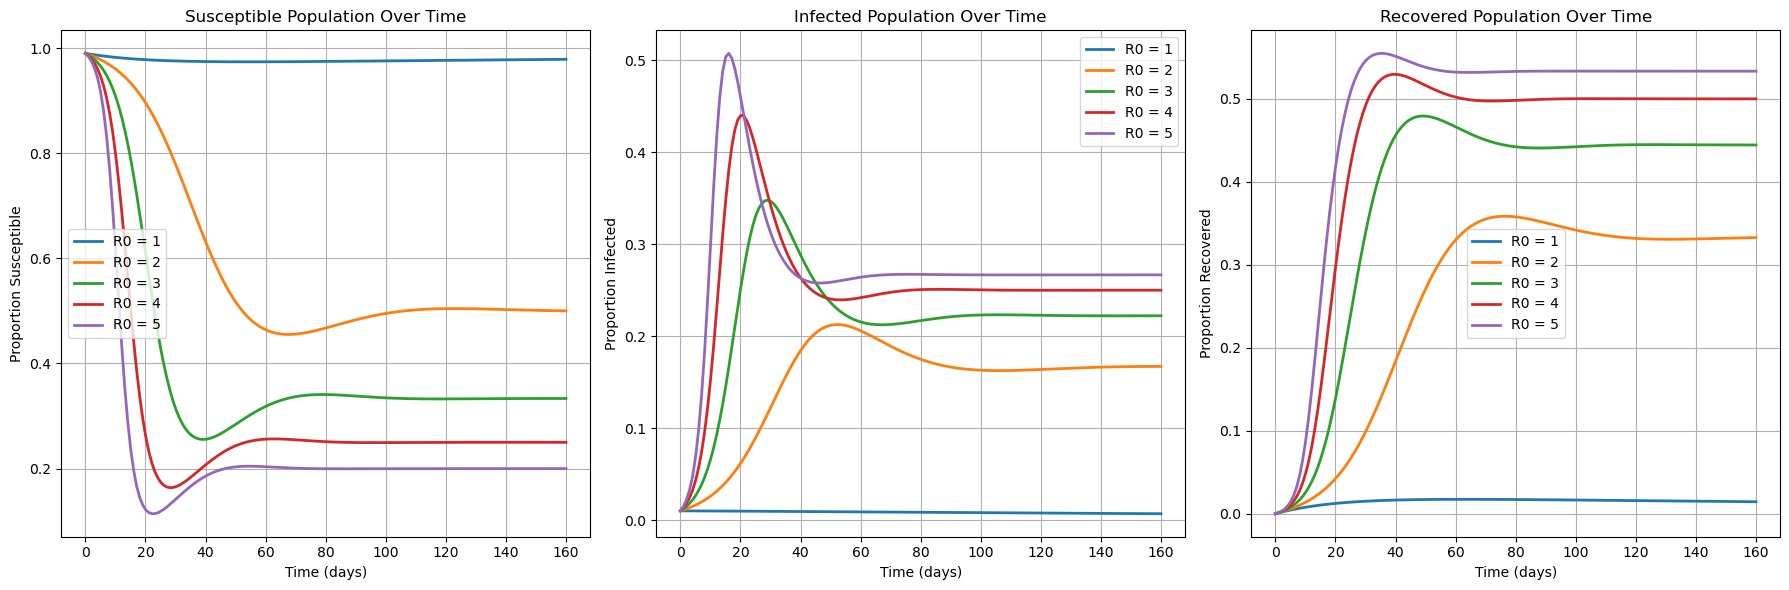

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
gamma = 0.1    # Recovery rate
delta = 0.05   # Rate of loss of immunity
R0_values = [1, 2, 3, 4, 5]  # Different R0 values to test

# Convert R0 values to corresponding beta values
beta_values = [R0 * gamma for R0 in R0_values]

# Initial conditions
S0 = 0.99      # Initial fraction of susceptible population
I0 = 0.01      # Initial fraction of infected population
R0_init = 0.0  # Initial fraction of recovered population
initial_conditions = [S0, I0, R0_init]

# Time points (days)
t = np.linspace(0, 160, 160)

# Store results for each R0 value
S_results = []
I_results = []
R_results = []

# SIRS model differential equations
def sirs_model(y, t, beta, gamma, delta):
    S, I, R = y
    dS_dt = -beta * S * I + delta * R  # Susceptibles increase as immunity wanes
    dI_dt = beta * S * I - gamma * I   # Infected individuals
    dR_dt = gamma * I - delta * R      # Recovered individuals lose immunity over time
    return [dS_dt, dI_dt, dR_dt]

# Solve the model for each beta (calculated from R0) and store results
for beta in beta_values:
    solution = odeint(sirs_model, initial_conditions, t, args=(beta, gamma, delta))
    S, I, R = solution.T
    S_results.append(S)
    I_results.append(I)
    R_results.append(R)

# Plotting all susceptibles, infecteds, and recovereds on separate graphs
plt.figure(figsize=(18, 6))

# Susceptible plot
plt.subplot(1, 3, 1)
for i, R0 in enumerate(R0_values):
    plt.plot(t, S_results[i], label=f'R0 = {R0}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Susceptible')
plt.title('Susceptible Population Over Time')
plt.legend()
plt.grid(True)

# Infected plot
plt.subplot(1, 3, 2)
for i, R0 in enumerate(R0_values):
    plt.plot(t, I_results[i], label=f'R0 = {R0}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Infected')
plt.title('Infected Population Over Time')
plt.legend()
plt.grid(True)

# Recovered plot
plt.subplot(1, 3, 3)
for i, R0 in enumerate(R0_values):
    plt.plot(t, R_results[i], label=f'R0 = {R0}', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion Recovered')
plt.title('Recovered Population Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


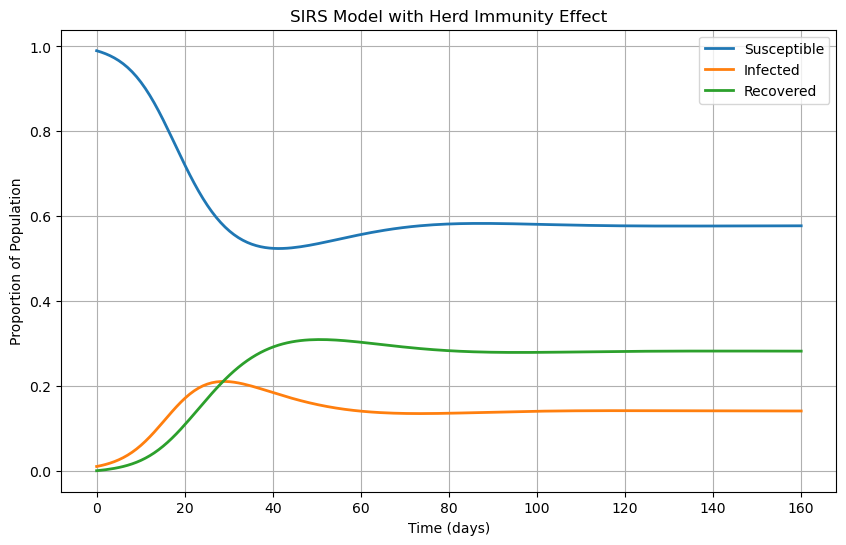

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.3    # Base infection rate
gamma = 0.1   # Recovery rate
delta = 0.05  # Rate of loss of immunity

# Herd immunity threshold
R0 = beta / gamma
herd_immunity_threshold = 1 - 1 / R0

# Initial conditions
S0 = 0.99     # Initial susceptible population fraction
I0 = 0.01     # Initial infected population fraction
R0_init = 0.0 # Initial recovered population fraction
initial_conditions = [S0, I0, R0_init]

# Time points (days)
t = np.linspace(0, 160, 160)

# SIRS model differential equations with herd immunity effect
def sirs_model(y, t, beta, gamma, delta, herd_immunity_threshold):
    S, I, R = y
    
    # Adjust infection rate based on the herd immunity threshold effect
    effective_beta = beta * (S / (S + I + R)) if S + I + R > herd_immunity_threshold else beta * (1 - herd_immunity_threshold)

    dS_dt = -effective_beta * S * I + delta * R    # Susceptibles gain from waning immunity
    dI_dt = effective_beta * S * I - gamma * I     # Infected individuals increase with effective transmission
    dR_dt = gamma * I - delta * R                  # Recovered individuals lose immunity over time
    return [dS_dt, dI_dt, dR_dt]

# Solve the differential equations
solution = odeint(sirs_model, initial_conditions, t, args=(beta, gamma, delta, herd_immunity_threshold))
S, I, R = solution.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', linewidth=2)
plt.plot(t, I, label='Infected', linewidth=2)
plt.plot(t, R, label='Recovered', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIRS Model with Herd Immunity Effect')
plt.legend()
plt.grid(True)
plt.show()


**Current ideas:**

- Find values to change beta values (maybe proportionally or using values from research) to mimic lockdowns / face mask wearing
- Read the two papers on GitHub
- Do the trends change when the population is taken into account?

## SEIR Model

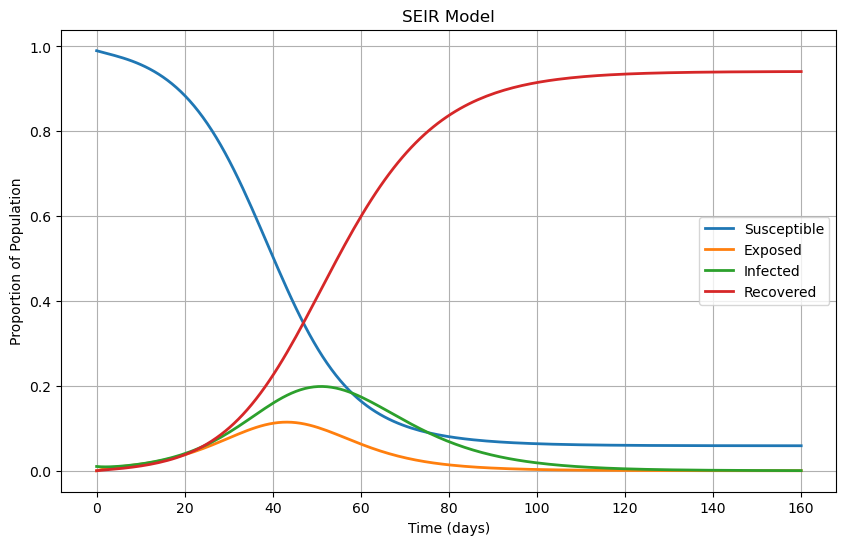

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.3   # Infection rate
sigma = 0.2  # Incubation rate (1/incubation period)
gamma = 0.1  # Recovery rate

# Initial conditions
S0 = 0.99     # Initial fraction of susceptible population
E0 = 0.0      # Initial fraction of exposed population
I0 = 0.01     # Initial fraction of infected population
R0 = 0.0      # Initial fraction of recovered population
initial_conditions = [S0, E0, I0, R0]

# Time points (days)
t = np.linspace(0, 160, 160)

# SEIR model differential equations
def seir_model(y, t, beta, sigma, gamma):
    S, E, I, R = y
    dS_dt = -beta * S * I              # Susceptible equation
    dE_dt = beta * S * I - sigma * E   # Exposed equation
    dI_dt = sigma * E - gamma * I      # Infected equation
    dR_dt = gamma * I                  # Recovered equation
    return [dS_dt, dE_dt, dI_dt, dR_dt]

# Solve the differential equations
solution = odeint(seir_model, initial_conditions, t, args=(beta, sigma, gamma))
S, E, I, R = solution.T

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', linewidth=2)
plt.plot(t, E, label='Exposed', linewidth=2)
plt.plot(t, I, label='Infected', linewidth=2)
plt.plot(t, R, label='Recovered', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SEIR Model')
plt.legend()
plt.grid(True)
plt.show()
